In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
df=pd.read_csv('Data/TimeSeriesData/Alcohol_Sales.csv',index_col=0,parse_dates=True)

In [3]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [5]:
df=df.dropna()

In [6]:
len(df)

325

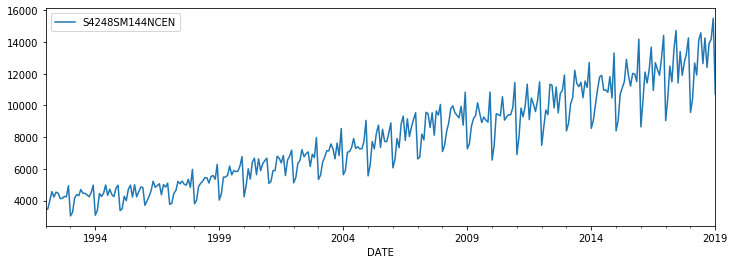

In [8]:
df.plot(figsize=(12,4))

In [9]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [10]:
y=df['S4248SM144NCEN'].values.astype(float)

In [12]:
test_size=12

In [13]:
train_set=y[:-test_size]
test_set=y[-test_size:]

In [14]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler=MinMaxScaler(feature_range=(-1,1))

In [17]:
scaler.fit(train_set.reshape(-1,1))

MinMaxScaler(copy=True, feature_range=(-1, 1))

In [18]:
train_norm=scaler.transform(train_set.reshape(-1,1))

In [21]:
train_norm=torch.FloatTensor(train_norm).view(-1)

In [22]:
train_norm

tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
        -0.8128, -0.7901, -0.7933, -0.6743, -1.0000, -0.9607, -0.8070, -0.7699,
        -0.7819, -0.7154, -0.7560, -0.7562, -0.7721, -0.7940, -0.7489, -0.6678,
        -0.9925, -0.9408, -0.7586, -0.7897, -0.7557, -0.6660, -0.7790, -0.7114,
        -0.7704, -0.7919, -0.7003, -0.6683, -0.9420, -0.9226, -0.7884, -0.8354,
        -0.7121, -0.6678, -0.7962, -0.6634, -0.7942, -0.7396, -0.6889, -0.6931,
        -0.8858, -0.8373, -0.7896, -0.7285, -0.6260, -0.6914, -0.6735, -0.6528,
        -0.7719, -0.6613, -0.6890, -0.6468, -0.8757, -0.8643, -0.7567, -0.7258,
        -0.6275, -0.6536, -0.6239, -0.6576, -0.6685, -0.6049, -0.6923, -0.4984,
        -0.8692, -0.8311, -0.6808, -0.6480, -0.6229, -0.5870, -0.5890, -0.6451,
        -0.5753, -0.5637, -0.6042, -0.4435, -0.8289, -0.7600, -0.5815, -0.5808,
        -0.5630, -0.4623, -0.5572, -0.5114, -0.5218, -0.5182, -0.4617, -0.3606,
        -0.7928, -0.6716, -0.4911, -0.60

In [23]:
window_size=12

In [24]:
def input_data(seq,ws):
    out=[]
    L=len(seq)
    for i in range(L-ws):
        window=seq[i:i+ws]
        label=seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [25]:
train_data=input_data(train_norm,window_size)

In [26]:
len(train_data)

301

In [27]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]), tensor([-1.]))

In [28]:
class LSTM(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,out_size=1):
        super().__init__()
        self.hidden_size=hidden_size
        self.lstm=nn.LSTM(input_size,hidden_size)
        self.linear=nn.Linear(hidden_size,out_size)
        self.hidden=(torch.zeros(1,1,hidden_size),torch.zeros(1,1,hidden_size))
    def forward(self,seq):
        lstm_out,self.hidden=self.lstm(seq.view(len(seq),1,-1),self.hidden)
        pred=self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

In [29]:
torch.manual_seed(101)
model=LSTM()
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=.001)

In [30]:
model

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [32]:
epochs=100
import time
start_time=time.time()
for epoch in range(epochs):
    for seq,y_train in train_data:
        optimizer.zero_grad()
        model.hidden=(torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
        y_pred=model(seq)
        loss=criterion(y_pred,y_train)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch}, Loss {loss.item()}')
duration=time.time-start_time
print(duration/60)

Epoch 0, Loss 0.25314345955848694
Epoch 1, Loss 0.37523898482322693
Epoch 2, Loss 0.3901209831237793
Epoch 3, Loss 0.349496990442276
Epoch 4, Loss 0.3307788074016571
Epoch 5, Loss 0.3323073089122772
Epoch 6, Loss 0.3266769051551819
Epoch 7, Loss 0.32077038288116455
Epoch 8, Loss 0.3065176010131836
Epoch 9, Loss 0.2951700687408447
Epoch 10, Loss 0.26913928985595703
Epoch 11, Loss 0.25979408621788025
Epoch 12, Loss 0.2459997683763504
Epoch 13, Loss 0.2222774624824524
Epoch 14, Loss 0.18593749403953552
Epoch 15, Loss 0.18445566296577454
Epoch 16, Loss 0.17432530224323273
Epoch 17, Loss 0.2582225203514099
Epoch 18, Loss 0.2242051064968109
Epoch 19, Loss 0.23121914267539978
Epoch 20, Loss 0.19758883118629456
Epoch 21, Loss 0.18989050388336182
Epoch 22, Loss 0.2104491889476776
Epoch 23, Loss 0.16945958137512207
Epoch 24, Loss 0.14590860903263092
Epoch 25, Loss 0.11834970861673355
Epoch 26, Loss 0.0001621616684133187
Epoch 27, Loss 0.0064497096464037895
Epoch 28, Loss 0.050497524440288544
Epo

TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'

In [35]:
future=12
preds=train_norm[-window_size:].tolist()
model.eval()
for i in range(future):
    seq=torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden=(torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [36]:
preds[window_size:]

[0.21764472126960754,
 0.7362536787986755,
 0.42575034499168396,
 0.8574904799461365,
 1.24961256980896,
 0.32853081822395325,
 0.8707497715950012,
 0.6814860105514526,
 0.601524293422699,
 0.9176154732704163,
 0.8960760235786438,
 0.18404555320739746]

In [38]:
true_predictions=scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))

In [39]:
true_predictions

array([[10153.61279707],
       [13187.21589413],
       [11370.92664303],
       [13896.39056244],
       [16190.1087271 ],
       [10802.2410212 ],
       [13973.95078894],
       [12866.85241872],
       [12399.11635438],
       [14248.0917109 ],
       [14122.09669992],
       [ 9957.07446349]])

In [40]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

In [41]:
x=np.arange('2018-02-01','2019-02-01',dtype='datetime64[M]')
x

array(['2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
       '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01'],
      dtype='datetime64[M]')

In [42]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', length=325, freq=None)

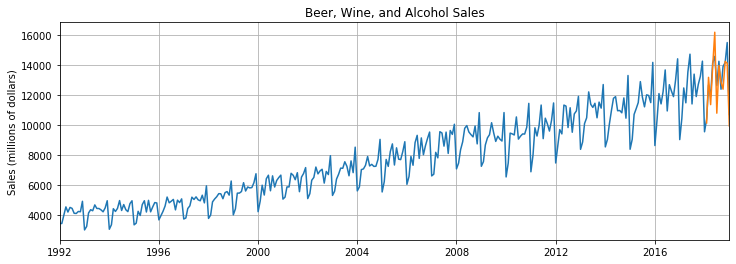

In [43]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

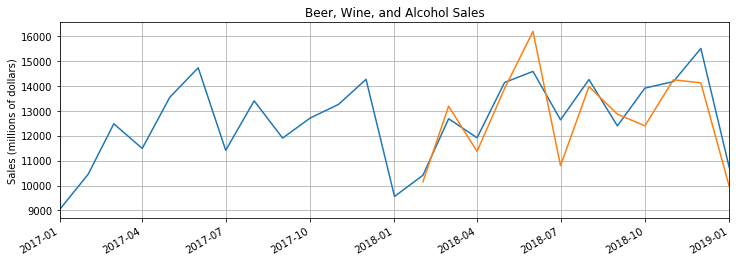

In [44]:
fig=plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

In [45]:
epochs = 100
model.train()
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)
import time
start_time = time.time()
for epoch in range(epochs):
    for seq, y_train in all_data:  
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size)) 
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.01454567
Epoch:  2 Loss: 0.01350383
Epoch:  3 Loss: 0.02643331
Epoch:  4 Loss: 0.01324219
Epoch:  5 Loss: 0.01439027
Epoch:  6 Loss: 0.01231953
Epoch:  7 Loss: 0.01169418
Epoch:  8 Loss: 0.01061528
Epoch:  9 Loss: 0.00724249
Epoch: 10 Loss: 0.00424754
Epoch: 11 Loss: 0.00208558
Epoch: 12 Loss: 0.00440567
Epoch: 13 Loss: 0.01001350
Epoch: 14 Loss: 0.00601961
Epoch: 15 Loss: 0.00487102
Epoch: 16 Loss: 0.00251737
Epoch: 17 Loss: 0.00400521
Epoch: 18 Loss: 0.00497501
Epoch: 19 Loss: 0.00461044
Epoch: 20 Loss: 0.00193556
Epoch: 21 Loss: 0.00038231
Epoch: 22 Loss: 0.00528781
Epoch: 23 Loss: 0.00042755
Epoch: 24 Loss: 0.00195656
Epoch: 25 Loss: 0.00191549
Epoch: 26 Loss: 0.00084451
Epoch: 27 Loss: 0.00021586
Epoch: 28 Loss: 0.00923860
Epoch: 29 Loss: 0.00273661
Epoch: 30 Loss: 0.00330967
Epoch: 31 Loss: 0.00159039
Epoch: 32 Loss: 0.00249826
Epoch: 33 Loss: 0.00335327
Epoch: 34 Loss: 0.00662615
Epoch: 35 Loss: 0.00236142
Epoch: 36 Loss: 0.00001399
Epoch: 37 Loss: 0.00416735
E

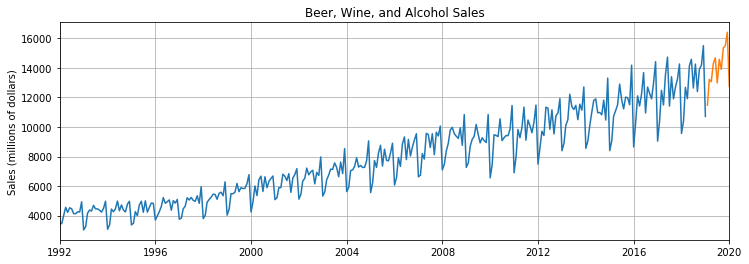

In [46]:
window_size = 12
future = 12
L = len(y)
preds = y_norm[-window_size:].tolist()
model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

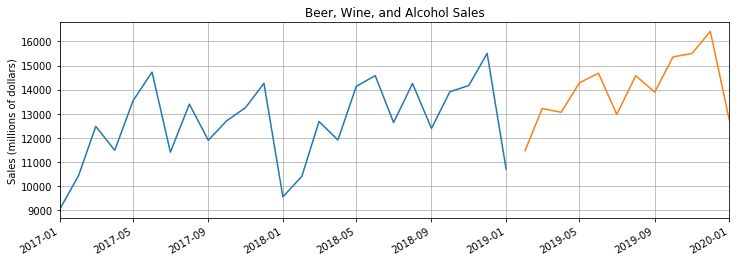

In [47]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()